In [1]:
from rfgap import RFGAP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataset import dataprep, load_regression
from phate import PHATE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import random
import json
import multiprocessing
from joblib import Parallel, delayed
import os

sns.set_theme()

In [2]:
json_dir = 'intervals/'

data = []

for filename in os.listdir(json_dir):
    if filename.endswith('.json'):

        filepath = os.path.join(json_dir, filename)
        series = pd.read_json(filepath, orient='records', typ='series')

        data.append(series)

df = pd.DataFrame(data)
df['level'] = df['level'].round(2)


In [3]:
json_dir_qrf = 'qrf_intervals/'

data_qrf = []

for filename in os.listdir(json_dir_qrf):
    if filename.endswith('.json'):

        filepath = os.path.join(json_dir_qrf, filename)
        series = pd.read_json(filepath, orient='records', typ='series')

        data_qrf.append(series)

df_qrf = pd.DataFrame(data_qrf)
df_qrf['level'] = df_qrf['level'].round(2)

In [4]:
df.head()

,data_name,n_neighbors,level,random_state,test_size,n,d,oob_score,test_score,coverage,width_mean,width_sd,width_min,width_q1,width_q2,width_q3,width_max
0,AirfoilSelfNoise,1000,0.8,1424,0.2,1503,5,0.929047,0.939969,0.787375,0.558624,0.003294,0.551086,0.556368,0.558412,0.560715,0.569262
1,AirfoilSelfNoise,1000,0.8,1679,0.2,1503,5,0.931532,0.921016,0.817276,0.591467,0.004108,0.583381,0.589737,0.590672,0.595351,0.598019
2,AirfoilSelfNoise,1000,0.8,1824,0.2,1503,5,0.935500,0.939585,0.857143,0.569110,0.003090,0.561692,0.568846,0.569253,0.570166,0.576286
3,AirfoilSelfNoise,1000,0.8,2286,0.2,1503,5,0.930411,0.924007,0.820598,0.608010,0.003708,0.602255,0.606187,0.606187,0.607820,0.615719
4,AirfoilSelfNoise,1000,0.8,3657,0.2,1503,5,0.932849,0.929926,0.794020,0.558336,0.001894,0.553570,0.557365,0.558369,0.560093,0.563470


In [5]:
df_qrf.head()

,data_name,n_neighbors,level,random_state,test_size,n,d,oob_score,test_score,coverage,width_mean,width_sd,width_min,width_q1,width_q2,width_q3,width_max
0,AirfoilSelfNoise,qrf,0.8,1424,0.2,1503,5,None,None,0.823920,0.778640,0.406924,0.090162,0.480818,0.730722,0.998064,2.720965
1,AirfoilSelfNoise,qrf,0.8,1679,0.2,1503,5,None,None,0.833887,0.789399,0.413840,0.002899,0.468265,0.732461,1.014284,2.808083
2,AirfoilSelfNoise,qrf,0.8,1824,0.2,1503,5,None,None,0.857143,0.724954,0.425916,0.085988,0.443275,0.627441,0.882781,2.720965
3,AirfoilSelfNoise,qrf,0.8,2286,0.2,1503,5,None,None,0.823920,0.752000,0.394019,0.026672,0.475455,0.697484,0.906118,2.359880
4,AirfoilSelfNoise,qrf,0.8,3657,0.2,1503,5,None,None,0.837209,0.766997,0.433269,0.050285,0.484877,0.655635,0.955940,2.958837


In [6]:
df_combined = pd.concat([df, df_qrf], axis=0)

In [7]:
pd.pivot_table(df_combined, values = ['width_mean'], index = ['level'], columns = ['n_neighbors'],
               aggfunc = np.mean, margins = False).reset_index().to_csv('temp_width_mean.csv')

In [8]:
pd.pivot_table(df_combined, values = ['width_sd'], index = ['level'], columns = ['n_neighbors'],
               aggfunc = np.std, margins = False).reset_index().to_csv('temp_width_std.csv')

In [9]:
pd.pivot_table(df_combined, values = ['coverage'], index = ['level'], columns = ['n_neighbors'],
               aggfunc = np.mean, margins = False).reset_index().to_csv('temp_coverage_mean.csv')

In [10]:
df_level_neighs = df_combined.groupby(['level', 'n_neighbors'])[['width_mean']].agg([np.mean, np.std]).reset_index()

df_level_neighs

level n_neighbors width_mean          
                           mean       std
0   0.80           5   0.481580  0.278850
1   0.80          10   0.554590  0.324455
2   0.80          20   0.600376  0.353748
3   0.80          50   0.632498  0.382350
4   0.80         100   0.635251  0.378191
5   0.80         200   0.606603  0.382009
6   0.80         500   0.686947  0.386116
7   0.80        1000   0.730509  0.413563
8   0.80        2000   0.688013  0.425257
9   0.80        5000   0.770621  0.384338
10  0.80       10000   0.810182  0.475650
11  0.80         all   0.645817  0.392433
12  0.80        auto   0.603494  0.361180
13  0.80         qrf   0.656320  0.377479
14  0.90           5   0.557709  0.322748
15  0.90          10   0.718332  0.411507
16  0.90          20   0.789651  0.453516
17  0.90          50   0.891612  0.519725
18  0.90         100   0.923168  0.536049
19  0.90         200   0.921089  0.589411
20  0.90         500   1.056027  0.614255
21  0.90        1000   1.140529  0.666367
22  0.90        2000   1.113525  0.720523
23  0.90        5000   1.255738  0.656784
24  0.90       10000   1.225455  0.702346
25  0.90         all   0.990608  0.612369
26  0.90        auto   0.808362  0.487168
27  0.90         qrf   0.860465  0.492762
28  0.95           5   0.595774  0.344742
29  0.95          10   0.800188  0.455593
30  0.95          20   0.977275  0.536425
31  0.95          50   1.117637  0.632659
32  0.95         100   1.203521  0.689153
33  0.95         200   1.243809  0.802448
34  0.95         500   1.426009  0.870185
35  0.95        1000   1.573290  0.964212
36  0.95        2000   1.570829  1.066566
37  0.95        5000   1.777384  0.992714
38  0.95       10000   1.686679  0.918336
39  0.95         all   1.347243  0.857294
40  0.95        auto   0.990524  0.598834
41  0.95         qrf   1.039375  0.594618
42  0.99           5   0.626225  0.362354
43  0.99          10   0.865664  0.491060
44  0.99          20   1.127439  0.604923
45  0.99          50   1.540682  0.824233
46  0.99         100   1.845863  0.996446
47  0.99         200   1.898453  1.121022
48  0.99         500   2.109884  1.254586
49  0.99        1000   2.388631  1.410430
50  0.99        2000   2.450849  1.573407
51  0.99        5000   3.009555  1.469171
52  0.99       10000   2.626777  1.565640
53  0.99         all   2.199863  1.233569
54  0.99        auto   1.223294  0.779537
55  0.99         qrf   1.337100  0.749902

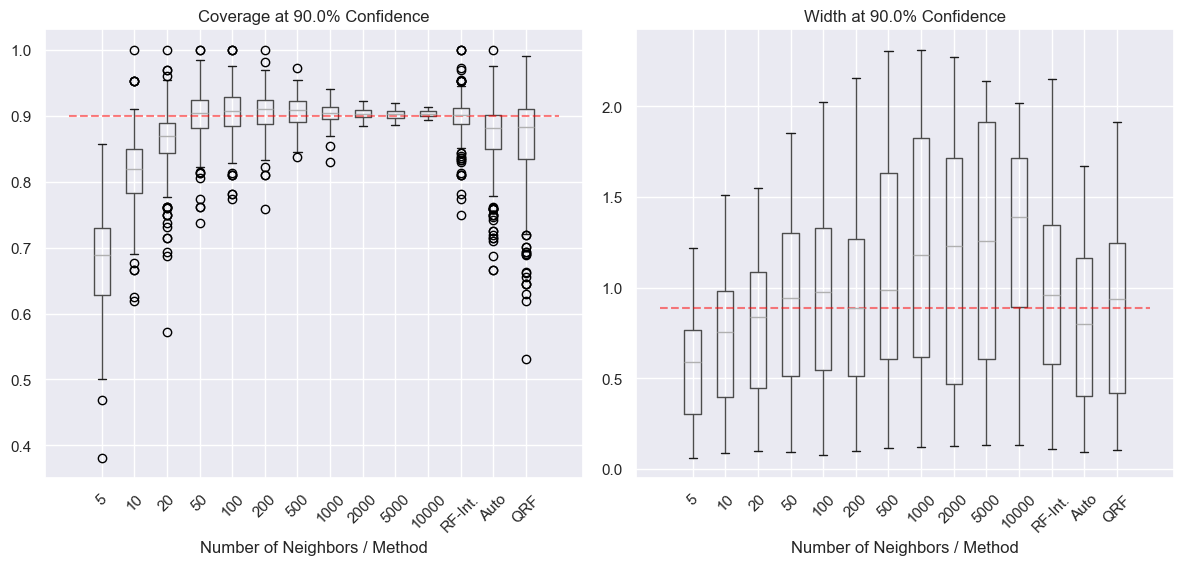

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
level = 0.90
df_level = df_combined[df_combined['level'] == level]

xtick_labels = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 'RF-Int.', 'Auto', 'QRF']

df_level.boxplot(column='coverage', by=['n_neighbors'], ax = ax[0])
ax[0].hlines(level, 0, 15, color = 'red', alpha = 0.5, linestyle = '--')
ax[0].set_title(f'Coverage at {level * 100}% Confidence')
ax[0].set_xticklabels(xtick_labels, rotation = 45)
ax[0].set_xlabel('Number of Neighbors / Method')

df_level.boxplot(column='width_mean', by=['n_neighbors'], ax = ax[1])
ax[1].hlines(df_level.width_mean.mean(), 0, 15, color = 'red', alpha = 0.5, linestyle = '--')
ax[1].set_title(f'Width at {level * 100}% Confidence')
ax[1].set_xticklabels(xtick_labels, rotation = 45)
ax[1].set_xlabel('Number of Neighbors / Method')

fig.suptitle('')
plt.tight_layout()
plt.savefig('coverage_width.pdf')



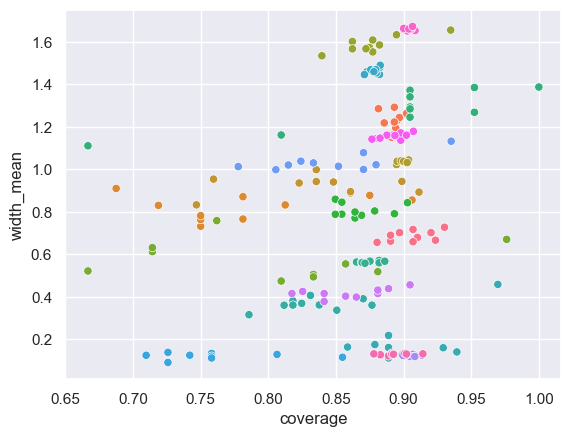

In [12]:
df_sub = df_combined[(df_combined['n_neighbors'] == 'auto') & (df_combined['level'] == 0.90)]

g = sns.scatterplot(data = df_sub, x = 'coverage', y = 'width_mean', hue = 'data_name')
g.legend([],[], frameon=False)

<Axes: title={'center': 'width_mean'}, xlabel='[n_neighbors]'>

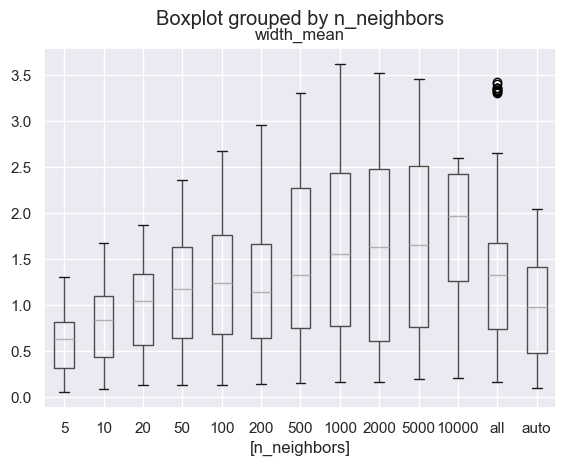

In [13]:
df[df['level'] == 0.95].boxplot(column='width_mean', by=['n_neighbors'])

<Axes: xlabel='data_name', ylabel='width_q1'>

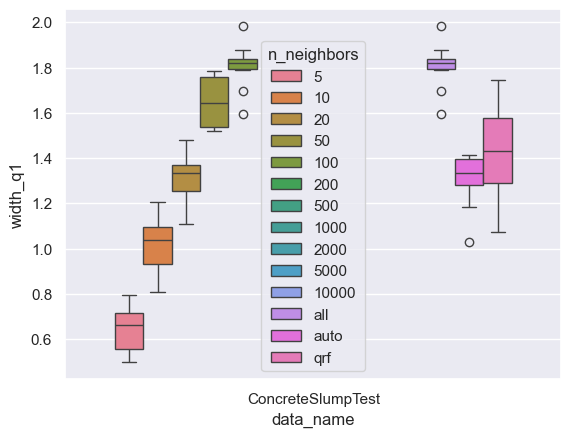

In [16]:
subset_df = df_combined[(df_combined['level'] == 0.95) & (df_combined['data_name'] == 'ConcreteSlumpTest')]
# subset_df = df[(df['level'] == 0.95)]

hue_order = [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 'all', 'auto', 'qrf']


sns.boxplot(subset_df, x = 'data_name', y = 'width_q1', hue='n_neighbors',
            hue_order = hue_order)

In [21]:
auto = df[df['data_name'] == 'AutoMPG']

In [23]:
auto_90 = auto[auto['level'] == 0.90]

In [17]:
# reg_table = df[['data_name', 'n', 'd']].drop_duplicates().reset_index(drop = True).to_latex(index = False)

# with open('reg_table.tex', 'w') as f:
#     f.write(reg_table)
